<div id="container" style="position:relative;">
<div style="float:left"><h1> Bagging and Random Forests </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

An ensemble model is a collection or an *ensemble* of many machine learning models, which are used to gain more predictive power. There any many ways that models will be combined. We will learn about two main types of ensemble methods:

* Bagging 
* Boosting

We will very lightly touch on Stacking, a different ensemble method.

In this lesson, we will focus on bagging. We will first start with a general description.

Let's get some helper functions for plotting:

In [3]:
def PlotBoundaries(model, X, Y, figsize=(8, 6)):
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.show()

In [4]:
def PlotEnsembleBoundaries(ensembles, X, Y, shape, figsize=(10, 7)):
    '''
    Helper function to plot the boundaries of ensemble methods.
    code modified from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html
    '''
    fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize)
    for i, (ax, model) in enumerate(zip(axes.ravel(), ensembles)):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.4)

        # Plot
        ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### Bagging

So far we've been exploring the use of single models; We'd create a model

`my_model = theModel(param1=value1, param2=value2, ...)`

Then fit it to the train data

`my_model.fit(X_train, y_train)`

and finally use the validation data to evaluate the model

`my_score = my_model.score(X_validation, y_validation)`

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

X = breast_cancer.data[:, [1, 9]]   # Grab two dimensions for visualization
y = breast_cancer.target


X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.3, random_state=19)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)


my_model = KNeighborsClassifier(n_neighbors=1)   # Build a model which overfits
my_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

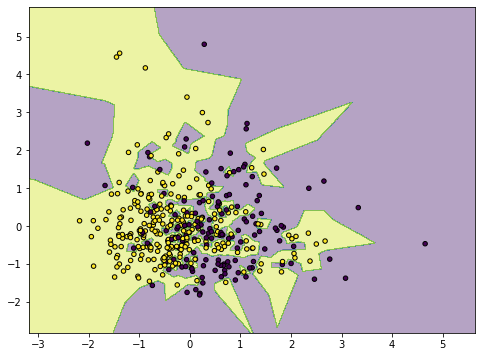

The classification accuracy of our model on the validation set is: 0.6666666666666666




In [6]:
PlotBoundaries(my_model, X_train, y_train)

print(f"The classification accuracy of our model on the validation set is: {my_model.score(X_validation, y_validation)}\n\n")

Sometimes we'd see our model can overfit to the data, and we'd try another set of parameters. However choosing the right set of hyperparameters can be a very long process.

An alternative approach is called bootstrap aggregation (*bagging*). In a bagging approach, we train several instances of our model, but each will see only a subset of the data. Then we "average out" the output of each model.

The intuition is that the commonalities between the subsets will get amplified, and the outliers' effect will be diminished.

### How does bagging work?


Bagging is composed of two operations, **bootstrapping** and **aggregation**. Aggregation refers to combining many models, where each model sees a subset of the data, and finding a way to average out their conclusions. We will touch on that a little later.

Bootstrapping is the way we show each model a subset of the data. To produce a bootstrapped sample from a dataset $X$, we produce a new dataset of the same size $X'$, but to create the new dataset we sample with replacement.

Let's see this in action:

In [7]:
def make_bootstrap_dataset(X):
    new_dataset = []

    indexes = np.arange(X.shape[0])
    while (len(new_dataset) < len(X)):

        # Choose a random sample
        random_index = np.random.choice(indexes, 1)[0]
        random_sample = X[random_index]

        # Put it into the new dataset
        new_dataset.append(random_sample)

    return np.array(new_dataset)

In [8]:
bootstrapped_sample = make_bootstrap_dataset(X_train)

print(X_train.shape)
print(bootstrapped_sample.shape)

(398, 2)
(398, 2)


The proportion of unique examples in our bootstrapped sample is usually $\approx63\%$

In [9]:
unique_element_count = np.unique(bootstrapped_sample, axis=0).shape[0]
print(unique_element_count/bootstrapped_sample.shape[0])

0.6482412060301508


Now we can employ this method to create new datasets, and train different models on each bootstrapped dataset. 

Scikit-Learn implements this this in the `BaggingClassifier` package under `sklearn.ensemble` (for complete documentation see: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier).

In [10]:
from sklearn.ensemble import BaggingClassifier

Say we wanted to fit an ensemble of KNN classifiers, (using the cancer dataset again):

In [11]:
from sklearn.neighbors import KNeighborsClassifier

breast_cancer = load_breast_cancer()

X = breast_cancer.data[:, [1, 9]]   # Grab two dimensions for visualization
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=19)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Fit several estimators
ensemble_of_KNN = BaggingClassifier(KNeighborsClassifier(
    n_neighbors=1), n_estimators=12, random_state=2)
ensemble_of_KNN.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1),
                  n_estimators=12, random_state=2)

We can visualize the decision boundary of the ensemble of KNN models:

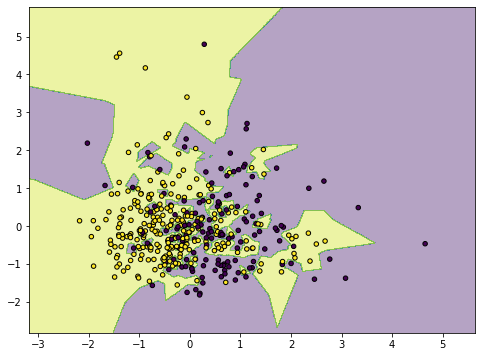

The classification accuracy of our model on the validation set is: 0.6842105263157895




In [12]:
PlotBoundaries(ensemble_of_KNN, X_train, y_train) 
print(f"The classification accuracy of our model on the validation set is: {ensemble_of_KNN.score(X_validation, y_validation)}\n\n")

And as before we can visualize the decision regions of each individual sub-model:

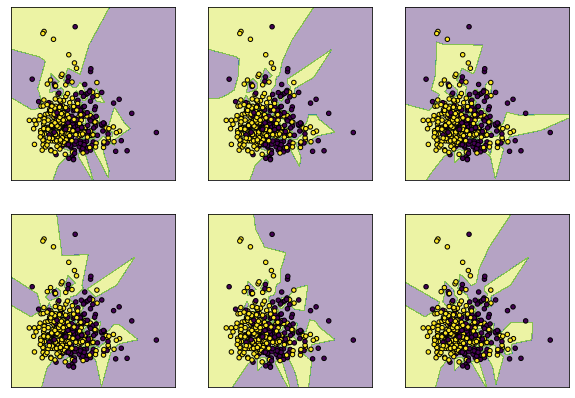

In [13]:
models = []
for model in ensemble_of_KNN.estimators_:
    models.append(model)

PlotEnsembleBoundaries(models, X_train, y_train, (2, 3))

The bagging model looks pretty similar to a KNN model and this isn't too surprising because it is comprised of several KNN models. Its decision boundaries are pretty close to each underlying component, which are each pretty similar to each other. The only difference is that the underlying models have been averaged out.

We could do the same with decision trees as well.

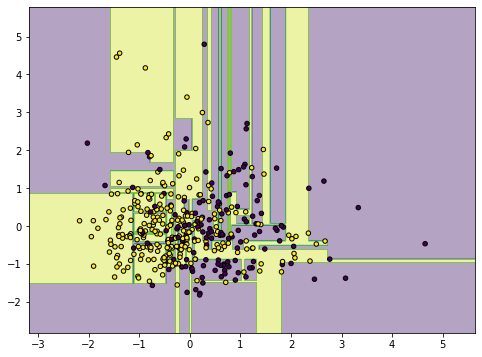

The classification accuracy of our model on the validation set is: 0.6257309941520468




In [14]:
from sklearn.tree import DecisionTreeClassifier

my_model = DecisionTreeClassifier()
my_model.fit(X_train, y_train)

PlotBoundaries(my_model, X_train, y_train)

print(f"The classification accuracy of our model on the validation set "
      f"is: {my_model.score(X_validation, y_validation)}\n\n")

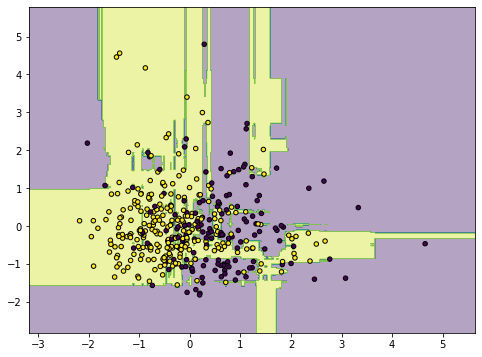

The classification accuracy of our model on the validation set is: 0.672514619883041




In [15]:
ensemble_of_DT = BaggingClassifier(DecisionTreeClassifier(),
                                   n_estimators=100,
                                   random_state=1)
ensemble_of_DT.fit(X_train, y_train)

PlotBoundaries(ensemble_of_DT, X_train, y_train)
print(f"The classification accuracy of our model on the validation set "
      f"is: {ensemble_of_DT.score(X_validation, y_validation)}\n\n")

### Soft vs. Hard Voting

Up until now we've said each sub-model contributes to the decision and we take some form of an average, but we haven't said how to do this. There are actually two ways of aggregating the sub-models, hard and soft.

Before we go into the difference in voting types we need to understand what each sub-model is doing when predicting what class $C$ a point $x$ belongs to. Formally when each sub-model $M$ is presented with $x$, it returns a probability distribution over the $C$ classes:

$$P(C=c | x)$$

This is a probability distribution, so we require:

$$\sum_c P(C=c | x) = 1$$

If we were not running an ensemble method and were just taking the decision of one classifier we would simply say the data point belonged to the most probable class according to our model. Formally this is:

$$argmax_c\{P(C=c | x)\}$$

But since we are aggregating the decision of many classes, we need some rule to combine probabilities.

### Hard Voting

In hard voting we combine the probabilities by having each model make an explicit vote, (that is we essentially ignore most of the information contained in the probabilities). We then count the votes across each sub-model to choose the overall winner. For example if we had three classes and four classifiers with the following probabilities for a data point $x$:

$$M_1(x) = (0.5,0.4,0.1), max = c_1$$
$$M_2(x) = (0.5,0.4,0.1), max = c_1$$
$$M_3(x) = (0.2.,0.5,0.3), max = c_2$$
$$M_4(x) = (0.2,0.3,0.5), max = c_3$$

Then hard voting would pick class $c_1$ for data point $x$ since it was the most commonly assigned one among the four models.

### Soft Voting

In soft voting we use all of the information contained in the model probabilities. We take the sum of the each probability and return the max over the total sums. The intuition is with hard voting we ignore the certainty of a model. In the previous example we took $c_1$ as the winner even though the two models that picked it were only slightly confident it was the best class. If we instead took the sum of all probabilities we would get:

$$\sum_i M_i(x) = (1.4,1.6,1.0)$$

Now we see the winner is $c_2$.

### Which models should we use?

We can use any model to build our bagging classifier, but there are a few things that make decision trees more convenient for bagging. So much so that there is a specialized model for a bagging ensemble of decision trees called a Random Forest (get it? because it's a collection of trees!)

### Random Forests

A random forest is an ensemble of decision trees. It's a model which was introduced by [Dr. Tin Kam Ho](https://en.wikipedia.org/wiki/Tin_Kam_Ho). It is a subset of the bigger ensemble type called bagging. 

First, let's dive a bit more deeply into decision trees and overfitting.

We'll use the following data:

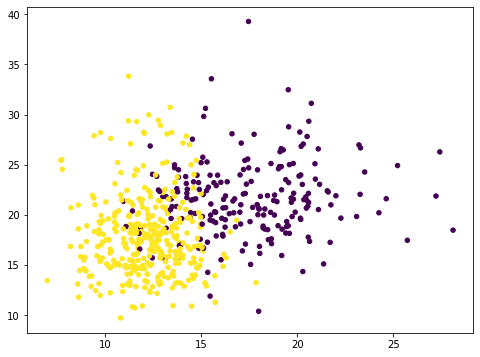

In [16]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

# Grab first two dimensions for visualization
X = breast_cancer.data[:, [0, 1]]
y = breast_cancer.target

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=20, c=y)
plt.show()

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.5, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.5, random_state=2)

There are two classes with some overlap in the middle, if we were to fit a decision tree:

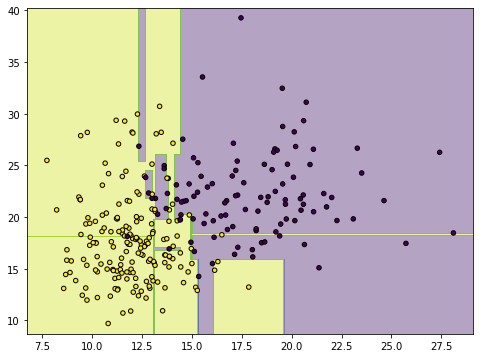

The classification accuracy is: 1.0


In [18]:
# fitting the DT
DT_model_one = DecisionTreeClassifier()
DT_model_one.fit(X_train1, y_train1)

PlotBoundaries(DT_model_one, X_train1, y_train1)

# Getting the score
print(f"The classification accuracy is: {DT_model_one.score(X_train1, y_train1)}")

This looks like it overfit a bit (look at the accuracy), especially in the middle of the data. If we were to fit another decision tree on some more data generated from the same distributions, we get:

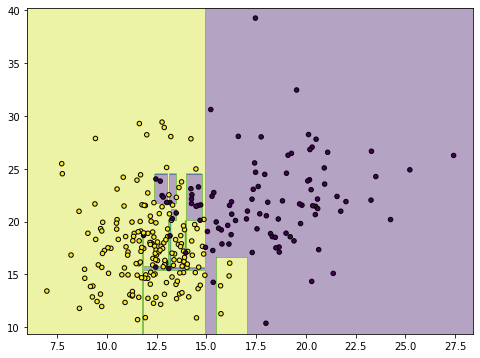

The classification accuracy is: 1.0


In [19]:
#fitting the DT
DT_model_two = DecisionTreeClassifier()
DT_model_two.fit(X_train2, y_train2)

PlotBoundaries(DT_model_two, X_train2, y_train2) 

#Getting the score
print(f"The classification accuracy is: {DT_model_two.score(X_train2, y_train2)}")

We see the decision boundaries are quite different now. The fact a decision tree is so sensitive to minor changes in the data is not a good sign for its ability to generalize. If we tested each decision tree on its test set (generated from the same distribution):

In [20]:
print(f"The classification accuracy of model one is: {DT_model_one.score(X_test1, y_test1)}")
print(f"The classification accuracy of model two is: {DT_model_two.score(X_test2, y_test2)}")

The classification accuracy of model one is: 0.856140350877193
The classification accuracy of model two is: 0.8245614035087719


There was a bit of overfitting to the underlying data.

We saw how to control overfitting by restricting the depth a tree can reach, this led to smoother decision boundaries like:

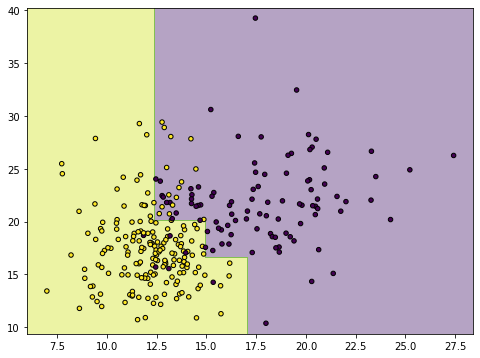

The classification accuracy of the regularized model is: 0.8596491228070176




In [21]:
#fitting the DT
DT_model = DecisionTreeClassifier(max_depth = 3)
DT_model.fit(X_train2, y_train2)

PlotBoundaries(DT_model, X_train2, y_train2) 
print(f"The classification accuracy of the regularized model is: {DT_model.score(X_test2, y_test2)}\n\n")

While this was not as overfit, it can be hard to pick the appropriate depth, and the boundaries we learn are not that great.

Another approach is to train several trees that each overfit to the underlying data in different ways and then average the results of each one.

We can do this with the `RandomForestClassifier` in `sklearn.ensemble`. We'll explain how to train these individual trees and what we mean by averaging in a bit, but for now we just need to know `n_estimators` controls the number of trees in our model 

For a full list of parameters see: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

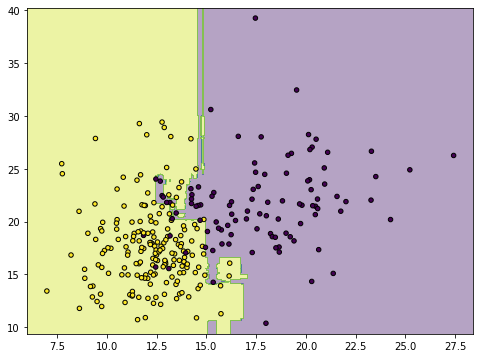

In [22]:
from sklearn.ensemble import RandomForestClassifier

my_random_forest = RandomForestClassifier(n_estimators=50)
my_random_forest.fit(X_train2, y_train2)
 
PlotBoundaries(my_random_forest, X_train2, y_train2) 

Here we have trained a random forest with 50 decision trees. If we wanted to visualize the decisions made by some of the trees we would run the following script:

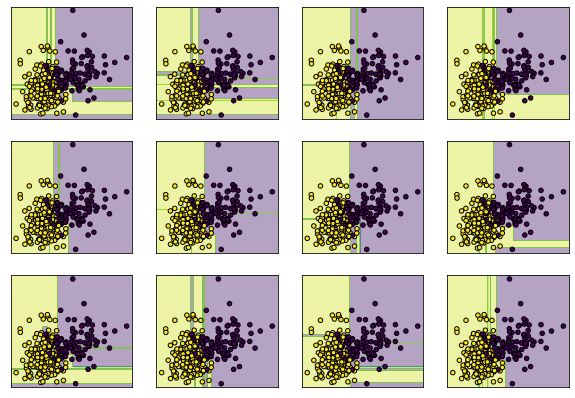

In [23]:
models = []
for model in my_random_forest.estimators_:
    models.append(model)
    
PlotEnsembleBoundaries(models, X_train2, y_train2, (3, 4));

As you can see, each tree has a different decision boundary. The general shape is similar, but they've each overfit to the data in different ways. The random forest is a type of average over all of these trees, the idea is that since the individual cases of overfitting are not common, they will disappear on average.

If we looked at the classification accuracy on the training data, we get: 

In [24]:
decision_tree_scores = []
for sub_tree in my_random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_train2, y_train2))
    
print("Performance on fitted data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {my_random_forest.score(X_train2, y_train2)}")

Performance on fitted data:
Average Decision Tree: 0.9528873239436619
Random Forest: 1.0


The random forest did quite well. It's important to notice that the average accuracy score over all decision trees is different than the random forest's accuracy score.

To assess how generalizable our model is, let's evaluate it on the test data:

In [25]:
decision_tree_scores = []
for sub_tree in my_random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_test2, y_test2))

print("Performance on Test data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {my_random_forest.score(X_test2, y_test2)}")

Performance on Test data:
Average Decision Tree: 0.8356491228070175
Random Forest: 0.8526315789473684


Again, the random forest performs better than the average performance of the trees inside it, and performs better than the individual decision trees we had before.

---
#### Exercise 1
1. Fit a random forest model to the following data set. Adjust the number of trees with `n_estimators` and discuss how the model performance changes on the train and test set.

2. You can control the complexity of the decision trees by using the `max_depth` parameter. Repeat the above exercise but keep the `max_depth` value at 1. How do your results compare?
---

In [26]:
# Loading data for exercise

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data
y = iris.target

# Add some noise to the data
random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = X + (random_state.randn(n_samples, n_features))

split = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=split, random_state=1)

In [27]:
### your code comes here
n_estimators = range(1, 100)

res = pd.DataFrame()
for n_est in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_est)
    rf.fit(X_train, y_train)
    
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    
    res = res.append({
        "n_estimators": n_est, "train": train_score, "test": test_score
    }, ignore_index = True)



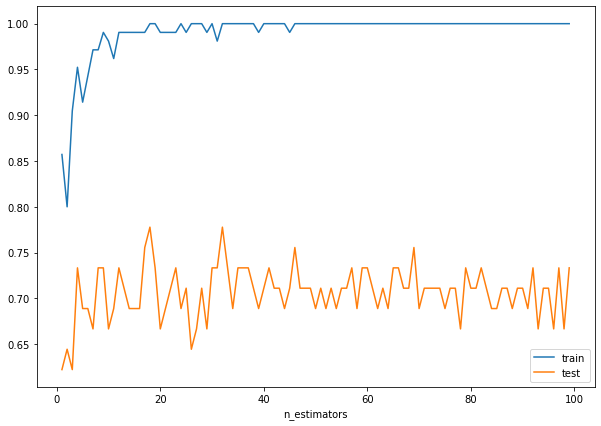

In [28]:
plt.figure(figsize = (10,7))
res.plot(x="n_estimators", y = ["train", "test"], kind = "line", ax = plt.gca())
plt.legend()
plt.show()

In [29]:
### your code comes here
n_estimators = range(1, 100)

res = pd.DataFrame()
for n_est in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth = 1)
    rf.fit(X_train, y_train)
    
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    
    res = res.append({
        "n_estimators": n_est, "train": train_score, "test": test_score
    }, ignore_index = True)



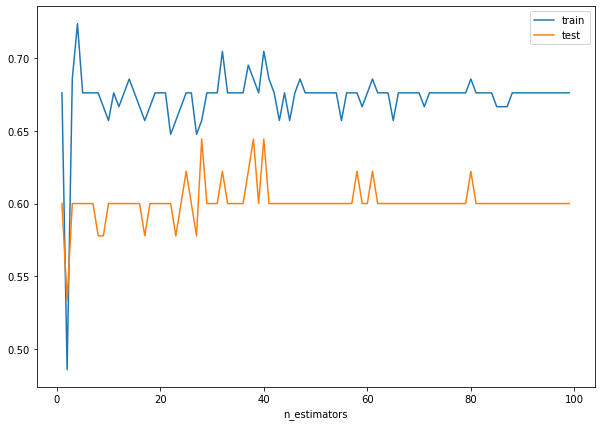

In [30]:
plt.figure(figsize = (10,7))
res.plot(x="n_estimators", y = ["train", "test"], kind = "line", ax = plt.gca())
plt.legend()
plt.show()

In [31]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)
feature_df = pd.DataFrame(
    {"importance":rf.feature_importances_},
    index = iris.feature_names
)
feature_df

,importance
sepal length (cm),0.168311
sepal width (cm),0.095146
petal length (cm),0.487866
petal width (cm),0.248677


### Building a Random Forest

In this section we'll look at how a random forest is built. In particular we will see how an individual decision tree is put together and how they are all combined.

#### Building a Decision Tree 

Each tree in the forest is fit to the data separately. That is, the decision made by one tree has no effect on the decision made by another. (Later on we will see how to build trees where the decisions do influence each other.) 

In addition we can use the `max_features` parameter to cause each tree to become more distinct. Recall, when a decision tree is making a split at a node it looks at every feature and picks one to split on. The value we give to `max_features` limits the number of features each node can consider, when making a split we randomly select `max_features` different features and split on one of them. This ensures each tree is sufficiently diverse, even if they are fit on similar data.

#### Combining the Decision Trees

When given a new data point $x$, our random forest will have each tree estimate which class it thinks $x$ belongs to. Once we have each tree's estimate of the class, we use soft voting to average the estimates to come to our final value.

### Voting

While the ensemble methods we've seen so far are powerful, they have one major limiting factor: **each ensemble contained only one type of classifier, with only one set of hyperparameters**. 

Recall that the original intention of using ensembles was to average out the errors each individual model makes, **but what if there is an underlying issue with the type of model itself?** If we create ensembles of a linear model, we may have a hard time dealing with the underlying issue of fitting non-linear data. This probably won't disappear when averaging out.

To get around this we can use the `VotingClassifier` in `sklearn.ensemble`. This allows us to fit an arbitrary ensemble of different models.

Let's say we wanted to fit an ensemble consisting of various models to the wine data set:

In [32]:
from sklearn.datasets import load_wine

wine = load_wine()

#Use two dimensions of wine for ease of visualization.
X = wine.data[:,3:5]
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [33]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# makes sure we all get the same results
np.random.seed(123)

KNN_model = KNeighborsClassifier()
SVM_model_one = SVC(kernel='linear', probability=True)
SVM_model_two = SVC(kernel='rbf', probability=True)

# Build the ensemble
voting_ensemble = VotingClassifier(estimators=[('KNN Model', KNN_model),
                                               ('SVM Model Linear', SVM_model_one),
                                               ('SVM Model RBF', SVM_model_two)],
                                   voting="soft",
                                   weights=[1, 1, 1])


voting_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('KNN Model', KNeighborsClassifier()),
                             ('SVM Model Linear',
                              SVC(kernel='linear', probability=True)),
                             ('SVM Model RBF', SVC(probability=True))],
                 voting='soft', weights=[1, 1, 1])

In [34]:
# makes sure we all get the same results
np.random.seed(123)

# use cross validation
scores = cross_val_score(voting_ensemble, X_train, y_train, cv=5)
scores_mean = round(scores.mean(),4)
print(scores_mean)

0.6135


In [35]:
# test score
voting_ensemble.score(X_test, y_test)

0.6666666666666666

We can visualize the decisions made by the ensemble:

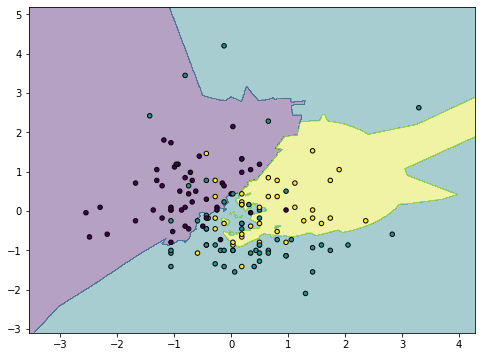

In [36]:
PlotBoundaries(voting_ensemble, X_train, y_train)

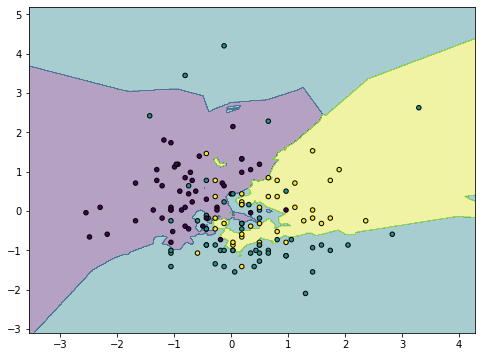

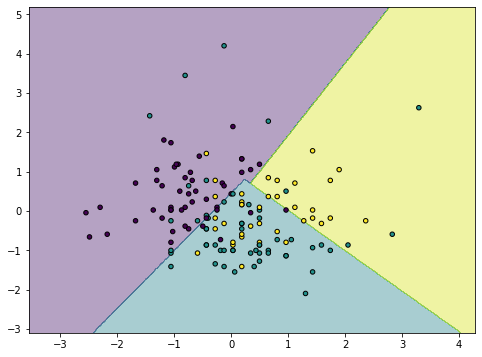

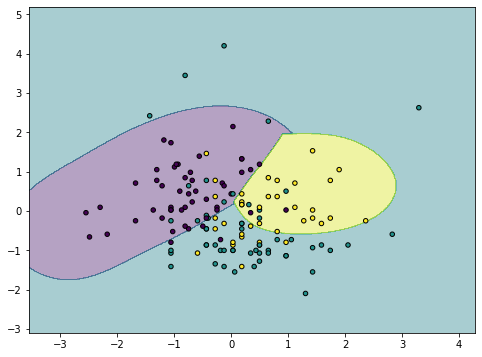

In [37]:
PlotBoundaries(voting_ensemble.estimators_[0], X_train, y_train);
PlotBoundaries(voting_ensemble.estimators_[1], X_train, y_train);
PlotBoundaries(voting_ensemble.estimators_[2], X_train, y_train);

Notice how the yellow region in the ensemble is much smaller than it is with the Linear SVM. This is because this SVM wasn't very confident about the further out areas being yellow while the KNN was confident they were blue. This leads to the ensemble assigning blue to them.

In general the shape of the ensemble is a blend of the two sub-methods. It roughly keeps the concave boundary between purple and blue, from the SVM, but blends in some of jaggedness of KNN.

### Hyperparameter Optimization

Like all of the models we've seen, the different hyperparameters of ensemble methods can be optimized. 

For *bagging* and *voting* we specify the parameters when creating each base model. The actual parameters are model-dependent. Earlier we made a voting ensemble of a KNN, Linear SVM, and Kernel SVM, the hyperparameters in question are specific to each model which is part of the classifier. For example, we can optimize the `n_neighbors` parameter in the KNN thats used in the ensemble to improve the overall ensemble performance.  

For Random Forests, the hyperparameters are mostly the same as those for Decision Trees. We set the parameters when creating the `RandomForestClassifier()` model object. 

As is often the case, the best practice is usually to try to perform some hyperparameter optimization when fitting models. However, the nature of ensemble methods, whereby we average results across many models, means that they generally perform well out of the box. 

---
#### Exercise 2

1. Fit an ensemble of KNN and SVMs to the following data set (try a linear and rbf kernel). What patterns in performance do you notice as you adjust which models are included in the ensemble?

2. Does it change the model performance if you switch from `soft` to `hard` voting? What happens when the weight of one model is much higher than the others?
---

In [38]:
# Load data for exercise

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Add some noise to the data
random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = X + (random_state.randn(n_samples, n_features))

split = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=split, random_state=1)

# Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Our first step is to set up the base classifiers:

In [39]:
# Q1
from sklearn.ensemble import VotingClassifier

estimators = [
    ("KNN", KNeighborsClassifier(n_neighbors=7)),
    ("SVM_linear", SVC(kernel='linear', probability=True)),
    ("SVM_rbf", SVC(kernel='rbf', probability=True))
]

We will see how each individual model performs and then their ensemble:

In [40]:
for name, model in estimators:
    # use cross validation
    scores = cross_val_score(model, X_train, y_train, cv=5)
    
    scores_mean = round(scores.mean(), 4)
    print(f"CV score for {name}: {scores_mean}")

CV score for KNN: 0.892
CV score for SVM_linear: 0.9322
CV score for SVM_rbf: 0.9247


Both SVMs scored around 92-93% while the KNN achieved 89%. We can now test the full ensemble:

In [41]:
np.random.seed(123)

# build the ensemble with equal weights and SOFT voting
ensemble = VotingClassifier(
    estimators=estimators,
    voting="soft",
    weights=[1, 1, 1]
)


scores = cross_val_score(ensemble, X_train, y_train, cv=5)
    
scores_mean = round(scores.mean(), 4)
print(f"CV score for the ensemble: {scores_mean}")

CV score for the ensemble: 0.9297


In this case, we see that the model is essentially at the same accuracy as the best individual predictor. In general, we would expect some improvement when using an ensemble over single models. We could check all combinations of model pairs as well but let's test instead if changing the voting type (from soft to hard) or the model weights has an effect.

In [42]:
# Q2
np.random.seed(123)

for i in range(3):
    # set up unequal weights
    weights = [1, 1, 1]
    weights[i] = 3
    
    # build the ensemble with unequal weights and SOFT voting
    ensemble = VotingClassifier(
        estimators=estimators,
        voting="soft",
        weights=weights
    )


    scores = cross_val_score(ensemble, X_train, y_train, cv=5)

    scores_mean = round(scores.mean(), 4)
    print(f"CV score for the ensemble with weigths {weights}: {scores_mean}")

CV score for the ensemble with weigths [3, 1, 1]: 0.9171
CV score for the ensemble with weigths [1, 3, 1]: 0.9347
CV score for the ensemble with weigths [1, 1, 3]: 0.9297


We achieved a new best score by weighting the linear SVM to the highest. If we rerun the experiment with hard voting, we get comparable but slightly lower accuracy scores.

In [43]:
np.random.seed(123)

for i in range(3):
    # set up unequal weights
    weights = [1, 1, 1]
    weights[i] = 3
    
    # build the ensemble with unequal weights and SOFT voting
    ensemble = VotingClassifier(
        estimators=estimators,
        voting="hard",
        weights=weights
    )


    scores = cross_val_score(ensemble, X_train, y_train, cv=5)

    scores_mean = round(scores.mean(), 4)
    print(f"CV score for the ensemble with weigths {weights}: {scores_mean}")

CV score for the ensemble with weigths [3, 1, 1]: 0.892
CV score for the ensemble with weigths [1, 3, 1]: 0.9322
CV score for the ensemble with weigths [1, 1, 3]: 0.9247


Keep in mind that the outcome of these experiments would change if you changed the training data set.

----

### Stacking (Bonus)

Stacking takes a slightly different approach. In everyday language, stacking is a way to train a strong model to learn from the successes and mistakes of a handful of weaker models. 

These weak models are called *base* classifiers. With stacking, we train base classifiers and then use their predicted outputs as inputs for a *meta-classifier*. The meta-classifier will learn how to weigh the predictions of the base classifiers to make the best classifications that it can.

![img](https://drive.google.com/uc?export=view&id=1_thNxEgx0yblhKJALXHKNXeMkhhor7Jw) 

Sklearn v0.22 has a Stacking Classifier implementation. If you do not have v.022, we recommend updating. 

In [41]:
from sklearn.ensemble import StackingClassifier

In [42]:
# Use the same data from the voting example

from sklearn.datasets import load_wine

wine = load_wine()

#Use two dimensions of wine for ease of visualization.
X = wine.data[:,3:5]
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
# Setting up our base models

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# makes sure we all get the same results
np.random.seed(123)

# We instantiate the base models, along with their names
base_models = [('KNN', KNeighborsClassifier()),
               ('SVM1', SVC(kernel='linear', probability=True)),
               ('SVM2', SVC(kernel='rbf', probability=True))]


# building the stacked model
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(penalty='l1', solver='saga'))

stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                               ('SVM1', SVC(kernel='linear', probability=True)),
                               ('SVM2', SVC(probability=True))],
                   final_estimator=LogisticRegression(penalty='l1',
                                                      solver='saga'))

In [45]:
# makes sure we all get the same results
np.random.seed(123)

# use cross validation
scores = cross_val_score(stacked_model, X_train, y_train, cv=5)
scores_mean = round(scores.mean(),4)
print(scores_mean)

0.6276


In [46]:
stacked_model.score(X_test, y_test)

0.6388888888888888

We can see that the stacked classifier didn't do much better than the voting classifier on this data. This doesn't mean that it is unnecessary. For large and complex datasets it is just another tool we can add to our tool bag. We usually want to try many different models and select the one that best fits the data we have.

### How do we train our base and meta models without overfitting?

One single train-test-split on our dataset isn't enough to train a full stacking classifier without risking overfitting. This is because the base classifiers and the meta-classifier must be trained on separate sets. 

We will need:
- 1 subset of the data for training/optimizing our base models
- 1 subset of the data for training/optimizing our meta-classifier 
    - This subset is first fed into the base models, whose outputs are then taken as inputs to the meta-classifier
- 1 subset of the data for performing final testing & evaluation


Splitting the data into these subsets, training each base model and training the meta-classifier can be done manually, or we can do it with the `StackingClassifier()` object as we did in the example above. We perform a single train-test-split, pass the Training set into the Stacking Classifier for training/validation, and save the Test set for final model evaluation. 

----------

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>
